In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from pathlib import Path
from Somatic_IV import MR_Egger_model

#### Required R package: timereg

# Abstract
Identifying causal drivers of cancer progression is crucial for developing effective anti-cancer therapies. However, disentangling causality from correlation remains challenging due to confounding factors within the complex genetic and transcriptomic landscapes of cancer.
To address this challenge, we introduce the Somatic Instrumental Variable analysis (Somatic-IV), which integrates genetic, transcriptomic, and clinical outcome data to identify candidate driver genes likely playing a causal role in disease progression. Somatic-IV estimates genetic-exposure and genetic-outcome associations, utilizing MR-Egger regression to estimate bias-reduced causal effects. 

# Load data

#### Load somatic alterations
A patient-by-gene matrix ($G$) with mutation or CNA events (1) or WT (0)
1. For putative oncogenes, only missense mutation and copy number amplification were considered as alterations
2. For putative tumor suppressor, all non-silent mutations and deep deletion were considered as alterations

In [2]:
mut_cn_mat = pd.read_csv('data/PAAD_mut_cn_mat.csv', index_col=0)

#### Load inferred protein activities
A patient-by-gene matrix ($X$) of inferred protein activity

In [3]:
proteinActivity = pd.read_csv('data/PAAD_proteinActivity_allSamples_h1ARACNe.csv', index_col=0)

#### Load patient metadata
A metadata with at least two columns "event" and "time_to_event" (i.e. patient outcomes $T$)  
("time_delay_entry" also required if "delay_entry" analysis is needed in the survival analysis)

In [4]:
metadata = pd.read_csv('data/PAAD_metadata.csv', index_col=0)

#### Load protein-protein interaction (PPI) network
A PPI network with at least two columns "Gene1" and "Gene2"  
The reference network (ReactomeFI) used in this viegnette was downloaded from here: https://reactome.org/download-data

In [5]:
PPI = pd.read_csv('data/FIsInGene_122921_with_annotations.txt', sep='\t')

#### Set up additional arguments

In [6]:
# Whether to consider delayed entry (left truncation) when running the Aalen additive hazard model
delay_entry = False 

# Output dir
output_dir = 'PAAD_PSD_MREgger'

# Disease indication under investigation
disease = 'PAAD'

# Whether to trim TCGA sample IDs
TCGA_process_ID = True

# Number of cores used for multi processing
n_process = 10

# Lasso method: Choose from "CV" or "BIC"
LASSO_method = 'CV'

# (Optional) Covariates to include in the somatic-IV model 
covariates = []

# Network propagation

In [7]:
## Adjacency matrix
G = nx.from_pandas_edgelist(PPI, 
                            'Gene1', 'Gene2', edge_attr=True)
A = nx.to_numpy_array(G)

## Normalize by row sums
row_sums = A.sum(axis=1)
Q = A / row_sums

## Compute a personalized page rank (PPR) matrix with a restart probability of 0.3
rst_prob = 0.3
n = Q.shape[0]
PPR = rst_prob*scipy.linalg.inv(np.eye(n)-(1.-rst_prob)*Q)

## Create a look up table for P0 of each gene
nodes = list(G.nodes())
gene2P0 = pd.DataFrame(np.eye(len(nodes)), index=nodes, columns=nodes)

# Prepare input data

In [8]:
genes_in_network = sorted(set(proteinActivity.index) & set(nodes))
samples = sorted(set(mut_cn_mat.index) & set(proteinActivity.columns))
IVs_in_network = sorted(set(mut_cn_mat.columns) & set(nodes))

# X0 includes samples with matched WES and RNA-Seq data
# X0_prime includes all samples with WES
X0 = mut_cn_mat.loc[samples, IVs_in_network]
X0_prime = mut_cn_mat.loc[:, IVs_in_network]

Y = proteinActivity.loc[genes_in_network, samples].T
Y = (Y-Y.mean())/Y.std()

#### Process TCGA patient IDs

In [9]:
if TCGA_process_ID:
    X0.index = X0.index.str[:12] # TCGA patient ID
    X0 = X0.groupby(X0.index).max()
    X0_prime.index = X0_prime.index.str[:12] # TCGA patient ID
    X0_prime = X0_prime.groupby(X0_prime.index).max()
    Y.index = Y.index.str[:12] # TCGA patient ID
    Y = Y.groupby(Y.index).median()

#### Create output Paths

In [10]:
Path(f'data/{output_dir}').mkdir(parents=True, exist_ok=True)
Path('tmp').mkdir(parents=True, exist_ok=True)

# Somatic-IV analysis
- Step 1 (Multivariate model, Network-regularized Lasso): Select a set of genes with somatic alterations as IVs that are associated with PSD’s inferred protein activity  
$X_i=\gamma_0+\sum^J_{j=1}\gamma_jG_{ij}+\epsilon^X_j$ (Eq. 1)
- Step 2 (Univariate OLS): Test the association of each individual IV with PSD’s inferred protein activity  
$X_i=\gamma_0+\gamma_jG_{ij}+\epsilon^X_j$ (Eq. 2)
- Step 3 (Aalen additive hazard model):  Test the association of each IV with patient outcomes  
$h(t|G_{ij})=h_0(t)+\Gamma_jG_{ij}$ (Eq. 3)
- Step 4 (MR-Egger): Perform a weighted regression to estimate the causal effect  
$\hat{\Gamma_j}=\beta_{0E}+\beta_E\hat{\gamma_j}$ (Eq. 4)  
where the weights are given by $\sigma_{Tj}^{-2}$ 

In [11]:
model = MR_Egger_model(output_dir, disease, genes_in_network, IVs_in_network, PPR, gene2P0, Y, X0, X0_prime, metadata, 
                       LASSO_method=LASSO_method, covariates=covariates)

In [12]:
MREggerResults = model.fit(n=n_process)

# Calculating IV weights
# 1. IV selection: Regulator-IVs (multivariate model)
            MSE     score         F   k
0                                      
A1CF   0.960393  0.115234  3.473127   6
AAK1   0.995990  0.180194  3.428891  10
AATF   0.968193  0.182909  2.872787  12
ABCA1  1.077047  0.000000       NaN   0
ABCA7  1.158281  0.000000  0.000000   1
# 2. BetaXG: Regulator-IV Associations (univariate OLS)
          coef  std err      t  P>|t|  [0.025  0.975]  F-statistic Regulator
BCL6   -0.6850    0.384 -1.786  0.076  -1.442   0.072       3.1880      A1CF
CDKN2A -0.4733    0.151 -3.137  0.002  -0.771  -0.175       9.8420      A1CF
DDR2    0.3455    0.299  1.154  0.250  -0.246   0.936       1.3320      A1CF
KAT6A   0.1906    0.363  0.525  0.600  -0.526   0.908       0.2754      A1CF
SMAD4  -0.3420    0.158 -2.166  0.032  -0.654  -0.030       4.6900      A1CF
# Build input data for the Aalen model
# 3. BetaYG: Survival-IV Associations (univariate Aalen model)


Loading required package: survival


           coef  std err       z  P-val
ABL2    0.00106   0.0111  0.0951  0.924
AKT2    0.02830   0.0184  1.5300  0.125
ARID1A  0.00413   0.0175  0.2360  0.813
ARNT   -0.00871   0.0106 -0.8220  0.411
ATM    -0.00502   0.0157 -0.3200  0.749
# 4. MR-Egger regression
            Beta_0E    Beta_E  Beta_0E_SE  Beta_E_SE  Beta_0E_025  \
Regulator                                                           
PITPNC1    0.029438 -0.080872    0.006606   0.013709     0.015559   
PRKAR2B    0.039451 -0.098539    0.012843   0.022450     0.011184   
PPARG     -0.012890  0.041703    0.006202   0.010161    -0.026288   
SMURF1    -0.021189  0.058727    0.008515   0.014564    -0.039932   
HMGA2     -0.005928  0.036544    0.005707   0.010194    -0.018026   

           Beta_0E_975  Beta_E_025  Beta_E_975  Beta_0E_t  Beta_E_t  \
Regulator                                                             
PITPNC1       0.043317   -0.109673   -0.052070   4.456170 -5.899115   
PRKAR2B       0.067718   -0.147950   -

#### Results are saved in "data/PAAD_PSD_MREgger"

# Visualization

In [13]:
from scipy.stats import t
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from adjustText import adjust_text
import matplotlib.ticker as mtick

#### Set up running parameters

In [14]:
gene = 'ZBED2'
output_dir = 'PAAD_PSD_MREgger'
disease = 'PAAD'

#### This function performs MR-Egger regression based on summary statistics

In [15]:
def MR_Egger_regression(lm_XG, lm_YG):
    BetaYG = lm_YG.loc[:, 'coef']
    BetaXG = lm_XG.loc[:, 'coef']
    seBetaYG = lm_YG.loc[:, 'std err']
    seBetaXG = lm_XG.loc[:, 'std err']
    
    BYG = BetaYG*np.sign(BetaXG) 
    BXG = abs(BetaXG)
    BXG = sm.add_constant(BXG)
    
    md = sm.WLS(BYG, BXG, weights=1/seBetaYG**2)
    mdf = md.fit()
    
    MREggerBeta0 = mdf.params[0]
    MREggerBeta1 = mdf.params[1]
    SE0 = mdf.bse[0]/min(1, np.sqrt(mdf.scale))
    SE1 = mdf.bse[1]/min(1, np.sqrt(mdf.scale))
    DF = len(BetaYG)-2
    
    MRBeta0_p = 2*(1-t.cdf(abs(MREggerBeta0/SE0),DF))
    MRBeta1_p = 2*(1-t.cdf(abs(MREggerBeta1/SE1),DF))
    MRBeta0_CI = MREggerBeta0 + np.array([-1,1])*t.ppf(0.975, df=DF)*SE0
    MRBeta1_CI = MREggerBeta1 + np.array([-1,1])*t.ppf(0.975, df=DF)*SE1
    

    MREggerResults = pd.DataFrame([MREggerBeta0, MREggerBeta1, SE0, SE1, MRBeta0_CI[0], MRBeta0_CI[1], MRBeta1_CI[0], MRBeta1_CI[1], 
                                   MREggerBeta0/SE0, MREggerBeta1/SE1, MRBeta0_p, MRBeta1_p]).T
    MREggerResults.columns = ['Beta_0E', 'Beta_E', 'Beta_0E_SE', 'Beta_E_SE', 'Beta_0E_025', 'Beta_0E_975', 'Beta_E_025', 'Beta_E_975', 
                                         'Beta_0E_t', 'Beta_E_t', 'Beta_0E_p', 'Beta_E_p']
    
    MREggerData = pd.concat([BXG['coef'], BYG, 1/seBetaYG**2, seBetaXG, seBetaYG, BetaXG], axis=1)
    MREggerData.columns=['BXG', 'BYG', 'Weight', 'seBetaXG', 'seBetaYG', 'BetaXG']
    
    return MREggerResults, MREggerData

#### Load summary statistics

In [18]:
lm_XG = pd.read_csv('data/{}/{}_OLS_XG.csv'.format(output_dir, disease), index_col=0)
lm_XG = lm_XG.loc[lm_XG['Regulator']==gene]
lm_YG = pd.read_csv('data/{}/{}_Aalen_TG.csv'.format(output_dir, disease), index_col=0)
lm_YG = lm_YG.loc[lm_YG['std err']>0]
index = lm_XG.index.intersection(lm_YG.index)

#### Perform MR-Egger on a single gene and visualize result

In [19]:
MREggerResults, MREggerData = MR_Egger_regression(lm_XG.loc[index], lm_YG.loc[index])

In [20]:
MREggerResults.index = [gene]
MREggerResults

,Beta_0E,Beta_E,Beta_0E_SE,Beta_E_SE,Beta_0E_025,Beta_0E_975,Beta_E_025,Beta_E_975,Beta_0E_t,Beta_E_t,Beta_0E_p,Beta_E_p
ZBED2,-0.009889,0.042906,0.007434,0.012708,-0.025949,0.006171,0.015451,0.070361,-1.330287,3.37621,0.20629,0.004964


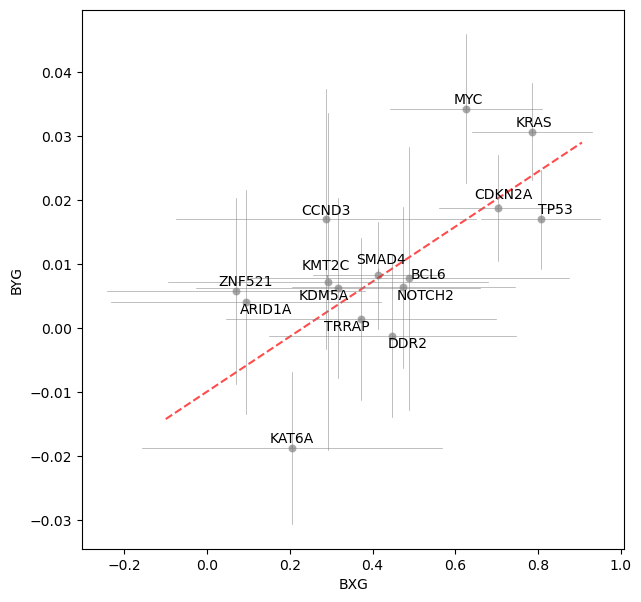

In [27]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax = sns.scatterplot(x='BXG', y='BYG', data=MREggerData, alpha=0.7, color='grey')
plt.plot([-0.1, MREggerData['BXG'].max()+0.1], 
         [MREggerResults.loc[gene, 'Beta_0E']-MREggerResults.loc[gene, 'Beta_E']*0.1, 
          MREggerResults.loc[gene, 'Beta_0E']+MREggerResults.loc[gene, 'Beta_E']*(MREggerData['BXG'].max()+0.1)], 
         linestyle='--', color='red', alpha=0.7)
    
texts = []
for index, row in MREggerData.iterrows():
    texts.append(ax.text(row['BXG'], row['BYG'], str(index), ha='center'))
    plt.plot([row['BXG']-row['seBetaXG'], row['BXG']+row['seBetaXG']], [row['BYG'], row['BYG']], color='grey', lw=0.5, alpha=0.7)
    plt.plot([row['BXG'], row['BXG']], [row['BYG']-row['seBetaYG'], row['BYG']+row['seBetaYG']], color='grey', lw=0.5, alpha=0.7)

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
plt.savefig('data/{}/{}_{}_MREgger_plot.PDF'.format(output_dir, disease, gene))